# A simple demonstration for the simulation of "GW + noise + anomaly" data 
The purpose is to showcase how to simulate data containing multiple GW signals, noises and anomalies (glitch for example). 
Users may go back to the former demos for more detailed explanations. 
Examples for faster GW response calculation and sensitivity analysis are also provided.

## Load the necessary libraries, set multiprocessing and logging messages 

In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *

import healpy as hlp

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

# if __name__ == "__main__":
#     multiprocessing.set_start_method("fork")

import multiprocessing

# ncpu = multiprocessing.cpu_count()
ncpu = 6
print("number of cpus =", ncpu)
pool = multiprocessing.Pool(processes=ncpu)

no cupy 


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


number of cpus = 6


INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.
INFO:Triangle.GW:Single-arm responses calculated.


## Settings for the simulation 

In [3]:
fsample = 1 / 10.0  # the sampling rate of data, default is 4 Hz.
data_time = 10.0 * DAY  # the time duration of simulation. The MicroSate orbit has a max length of 110 days, and simulation based on this orbit should not exceed this limit.
size = int(data_time * fsample)  # size of the simulated time series.
interp_order = 31  # order of lagrange interpolation, default is 31. Here we use a high order of interpolation since the simulation includes noises. For GW-only simulation, order=15 usually suffices.

default_noise = True  # whether to use the default noise models (True), or to modify some of the noise components in the middle of simulation (False).
TDI_method = "fast_michelson"  # method to calculate TDI combination, options: 'fast_michelson', 'channel_name', 'channel_path', 'channel_operator'.

## Set the models of orbit, offsets, and noises

In [4]:
# initialize orbit model from orbit data file
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

# set the drifts of lasers and clocks
offset = OffsetFunctions(laser_flag=False, clock_flag=False)

# initialize the models of basic instrumental noises
noise = InstrumentalPSDs(L=L_nominal)

## Define GW signals 

### 1. Initialize GB waveforms 

In [5]:
gw_gb = Initialize_GW_response(
    signal_type="GB",
    parameters={
        "A": 1.39879192e-22,
        "f0": 0.00984299,
        "fdot0": 4.31168731e-16,
        "phase0": 0.79960729,
        "inclination": 2.29680093,
        "longitude": 4.50950561,
        "latitude": -0.30076513,
        "psi": 3.08152927,
    },
    orbit=orbit,
)

initializing responses.


100%|██████████| 1/1 [00:00<00:00, 10058.28it/s]

responses initialized.


### 2. Initialize MBHB waveforms

In [6]:
gw_mbhb = Initialize_GW_response(
    signal_type="MBHB",
    parameters={
        "chirp_mass": 400000.0,
        "mass_ratio": 0.3640815267051051,
        "spin_1z": 0.7899406190510447,
        "spin_2z": 0.015424596359292053,
        "coalescence_time": 5.0,
        "coalescence_phase": 3.2535342675592966,
        "luminosity_distance": 106039.10941463517,
        "inclination": 1.4495086550199021,
        "longitude": 3.032776598141215,
        "latitude": -1.1817968279048852,
        "psi": 0.2409146690555858,
    },
    orbit=orbit,
    approximant="SEOBNRv4_opt",
)

initializing responses.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

responses initialized.


### 3. Initialize custom GW waveform (EMRI for example)

In [7]:
waveform_data = np.load("../GWData/Demo_EMRI_waveform_data.npz")
tdata, hpdata, hcdata = waveform_data["t"], waveform_data["h1"], -waveform_data["h2"]  # since h2 is -hx

gw_emri = Initialize_GW_response(
    signal_type="general",
    parameters={
        "longitude": np.random.uniform(0, TWOPI),
        "latitude": np.arcsin(np.random.uniform(-1, 1)),
        "psi": np.random.uniform(0, PI),
    },
    orbit=orbit,
    data=[
        [tdata, hpdata, hcdata],
    ],
)

initializing responses.


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

responses initialized.


### 4. Initialize SGWB signals

In [8]:
# define the SGWB fractional density
def Omega_SGWB(f, Omega0, f0, n):
    return Omega0 * (f / f0) ** n


# define the PSD of polarizations
def S_SGWB(f, Omega0=1e-11, f0=3.162e-3, n=-1.0):
    Omega = Omega_SGWB(f, Omega0, f0, n)
    return 3.0 * H0**2 / 4.0 / np.pi**2 / f**3 * Omega * 1e6 / MPC**2


# get the sky locations
NSIDE = 5
NPIX = hlp.nside2npix(NSIDE)  # number of pixels in the whole sky
print("number of directions:", NPIX)
colatitude, longitude = hlp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX))
latitude = np.pi / 2.0 - colatitude

# generate stochastic signals in all the directions
tdata = np.arange(size) / fsample
sgwb_generator = GeneralNoise(S_SGWB)
gw_sgwb = []
for i in tqdm(range(NPIX)):
    hp_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX)
    hc_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX)
    Waveform_k = GeneralWaveform(tdata=tdata, hpdata=hp_k, hcdata=hc_k)
    GW_k = GW(orbit=orbit, ext_params=[longitude[i], latitude[i], 0.0], GWwaveform=Waveform_k)  # here we set psi=0 since it is absorbed to h+ and hx
    gw_sgwb.append(GW_k)

number of directions: 300


100%|██████████| 300/300 [00:08<00:00, 35.59it/s]


### 5. Combine all GW signals

In [9]:
# the responses will be calculated in parallel
gw = gw_gb + gw_mbhb + gw_emri + gw_sgwb

## Interferometey simulation 
we only turn on the test-mass acceleration noises and the read out noises of interferometers, since these two are regarded as the main contributors to the  noise floor of TDI data. 

In [10]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame="ProperTime",  # the time frame of data, 'ProperTime' for the proper times of SCs, 'ClockTime' for the times of on-board clocks (with clock drifts and jitters), default is "ProperTime".
    acc_noise=True,  # switch of acceleration noise, default is True (this default value also applies to other noises).
    ro_noise=True,  # switch of readout noise
    laser_noise=False,  # switch of laser frequency noise
    clock_noise=False,  # switch of clock noise
    ob_noise=False,  # switch of optical bench displacement noise
    bl_noise=False,  # switch of fibre backlink noise
    op_noise=False,  # switch of optical path noise (all optical paths)
    ranging_noise=False,  # switch of pseudo ranging noise
    modulation_noise=False,  # switch of sideband modulation noise
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw,
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,  # whether to clean some intermediate variables to save memory
)

INFO:Triangle.Interferometer:Simulating data with sampling frequency 0.1 Hz.
INFO:Triangle.Interferometer:size = 86400
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:The simulation contains GW signal.


In [11]:
if default_noise:
    # simulate interferometric measurements
    ifo.SimulateInterferometers()

else:
    # break the ifo.SimulateInterferometer() function into steps so that we can modify the intermediate variables
    ifo.SimulateBasicNoise()

    # As an example, you can modify the amplitudes of inter-spacecraft interferometer's readout noises here
    # This is also how we replace the ACC noises generated from theoretical PSD with those generated from DFACS simulation in the Taiji Data Challenge.
    for key in MOSA_labels:
        ifo.BasicNoise["ro_sci_c_noise"][key] *= np.random.uniform(1.5, 2.5)

    ifo.SimulateRangeAndClock()

    # you also can add a glitch to the acceleration noise of test-mass 12 here
    TM_idx = "12"  # the index of TM where glitch happens
    glitch = Glitch(fsample=ifo.fsample)
    glitch_simulation_time = ifo.proper_time[TM_idx[0]]  # generate glitch according to the proper time of spacecraft 1
    glitch_injection_time = 100000.0  # set injection time
    short_glitch_acc = glitch.LPF_legacy_glitch_model(t=glitch_simulation_time, t0=glitch_injection_time, **glitch.short_glitch_kwargs)  # generate glitch in the acceleration unit
    short_glitch_ffd = glitch.acc2ffd(short_glitch_acc)  # convert to the fractional frequency difference unit, which is the default unit of BasicNoise["acc_noise"]
    ifo.BasicNoise["acc_noise"][TM_idx] += short_glitch_ffd  # inject glitch

    if ifo.gw_flag:
        ifo.SimulateGW()
    ifo.SimulateMeasurements()

# output simulation results to a directionary
m = ifo.OutputMeasurements(mode="decomposed")

# synchronize to TCB
m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)

ifo.clean()
m1.keys()

INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:303 GW signals will be generated.
INFO:Triangle.Interferometer:GW responses generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating offsets.
INFO:Triangle.Interferometer:Offsets generated.
INFO:Triangle.Interferometer:Generating fluctuations.
INFO:Triangle.Interferometer:Flutctuations generated.
INFO:Triangle.Interferometer:Total measurements constructed.
INFO:Triangle.Interferometer:Removing starting

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

## Simulate TDI processing

In [12]:
# initialize TDI with the input data
tdi_interp_order = 31  # the order of lagrange interpolation, default is 31.
tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=tdi_interp_order)

# calculate \xi_ij, the doppler argument decides whether to use the doppler delay operator
tdi.CalculateXi(doppler=True, pool=pool)

# calculate \eta_ij
tdi.CalculateEta(doppler=True)

if TDI_method == "fast_michelson":  # channel = "X", "XYZ", or "AET"
    tdi.FastMichelson(doppler=True, channel="AET")

elif TDI_method == "channel_name":  # only valid for "X1", "X2", "alpha1", "alpha2"
    tdi.CalculateBasicTDI(channel="X2", doppler=True, channel_name="X2")

elif TDI_method == "channel_path":  # e.g. ['121313121', '131212131'] for X2. Y2 and Z2 can be obtained by the permutation rule: 1->2, 2->3, 3->1
    tdi.CalculateBasicTDI(channel=["121313121", "131212131"], doppler=True, channel_name="X2")

elif TDI_method == "channel_operator":
    # "ij" represents the delay operator D_{ij}, while "-ij" stands for the corresponding "advance" operator A_{ij}
    # X2 can be constructed from the following opeator. Y2 and Z2 can be obtained by the permutation rule: 1->2, 2->3, 3->1
    X2_string = {
        "12": [(1.0, []), (-1.0, ["13", "31"]), (-1.0, ["13", "31", "12", "21"]), (1.0, ["12", "21", "13", "31", "13", "31"])],
        "23": [],
        "31": [(-1.0, ["13"]), (1.0, ["12", "21", "13"]), (1.0, ["12", "21", "13", "31", "13"]), (-1.0, ["13", "31", "12", "21", "12", "21", "13"])],
        "21": [(1.0, ["12"]), (-1.0, ["13", "31", "12"]), (-1.0, ["13", "31", "12", "21", "12"]), (1.0, ["12", "21", "13", "31", "13", "31", "12"])],
        "32": [],
        "13": [(-1.0, []), (1.0, ["12", "21"]), (1.0, ["12", "21", "13", "31"]), (-1.0, ["13", "31", "12", "21", "12", "21"])],
    }
    X2 = tdi.CalculateTDIFromPStrings(X2_string, doppler=True)
    tdi.measurements["X2"] = X2

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

### plot in time domain 
the time-domain plot shows a significant peak at the merger time of MBHB

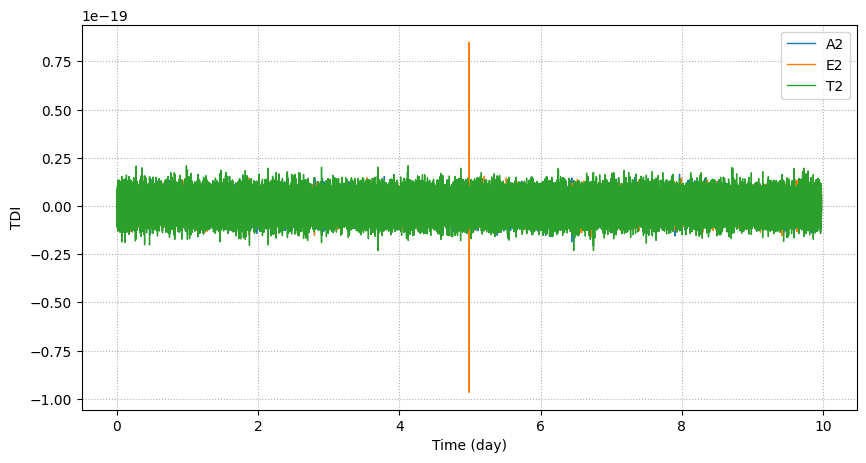

In [13]:
plt.figure(figsize=(10, 5))
for channel_name in ["A2", "E2", "T2"]:
    plot_data = tdi.measurements[channel_name][100:-100] / F_LASER
    plot_time = np.arange(len(plot_data)) / fsample / DAY
    plt.plot(plot_time, plot_data, label=channel_name, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper right")
plt.grid(linestyle=":")

### plot in frequency domain 
the frequency-domain plot shows a peak at the initial frequency of GB. 

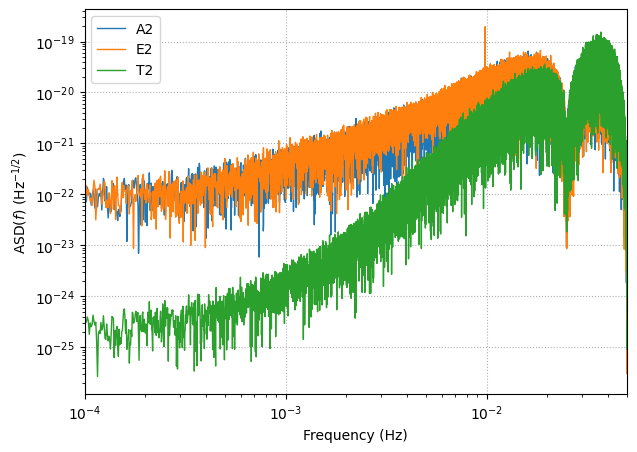

In [14]:
plt.figure(figsize=(7, 5))
for channel_name in ["A2", "E2", "T2"]:
    plot_data = tdi.measurements[channel_name][100:-100] / F_LASER
    ff, xf = PSD_window(plot_data, fsample=fsample, nbin=1, window_type="hann")
    plt.loglog(ff, np.sqrt(xf), label=channel_name, linewidth=1)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD}(f) \ ({\rm Hz}^{-1/2}) $")
plt.legend(loc="upper left")
plt.xlim(1e-4, 0.05)
plt.grid(linestyle=":")

## A faster implementation for the idealistic TDI responses of GW signals 
There is also a faster calculator for the TDI response of GW signals called ``GeneralTDIResponse``.  
In this implementation we neglect all the instrumental noises and imperfections, and assume all the results are prefectly synchronized to TCB.   
The speed of calculation can be further boosted by running in parallel on CPU or GPU (GPU acceleration is currently only available for GB waveforms).    
The TDI scheme is specified by $\bm{\rm P}_{ij}$ strings.    
``GeneralTDIResponse`` is what we actually use to generate the signals of TDC II, where we set ``return_eta`` = True and ``Pstring`` = eta since single-link responses $\eta_{ij}$ are desired.

For the default Michelson channels, further acceleration (5 $\sim$ 10 $\times$) can be achieved using the ``FastMichelsonTDIResponse`` class with a similar interface.     
It parallels on both GPU and CPU, and the speed is 1-year GB XYZ response on a $\sim$ 0.1 s timescale (NVIDIA RTX4080super).

In [31]:
# set the TCB times of resulting TDI responses
Tobs = 100 * DAY
dt = 10.0
tcb_times = np.arange(int(Tobs / dt)) * dt

# orbit model
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

# again, we use 2nd-generation X channel for example
X2_string = {
    "12": [(1.0, []), (-1.0, ["13", "31"]), (-1.0, ["13", "31", "12", "21"]), (1.0, ["12", "21", "13", "31", "13", "31"])],
    "23": [],
    "31": [(-1.0, ["13"]), (1.0, ["12", "21", "13"]), (1.0, ["12", "21", "13", "31", "13"]), (-1.0, ["13", "31", "12", "21", "12", "21", "13"])],
    "21": [(1.0, ["12"]), (-1.0, ["13", "31", "12"]), (-1.0, ["13", "31", "12", "21", "12"]), (1.0, ["12", "21", "13", "31", "13", "31", "12"])],
    "32": [],
    "13": [(-1.0, []), (1.0, ["12", "21"]), (1.0, ["12", "21", "13", "31"]), (-1.0, ["13", "31", "12", "21", "12", "21"])],
}

#### 1) for GB waveforms 

In [32]:
# Create a generator for the unprojected waveforms
gb_waveform_generator = GB_Injection(use_gpu=False)

# Create a generator for the TDI responses. The initialization takes a while, but it only needs to be run once.
# After the first call, the calculator can be run repeatedly with different source parameters.
# Interpolation is used dfferently from the Interferometer and TDI modules. For GBs (with f0 < 2e-2 Hz), linear interpolation should be enough.
# While we recommand linear_interp = False for more complex waveforms such as MBHBs and EMRIs.
gb_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=X2_string,
    tcb_times=tcb_times,
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=True,
    return_eta=False, 
)

In [33]:
# set source parameters
GB_params = {"A": 1.52072235e-22, "f0": 0.00261367, "fdot0": 3.34732748e-17, "phase0": 3.42918555, "inclination": 1.5166699, "longitude": 1.7686, "latitude": 0.10127302, "psi": 0.94753924}

# generate multiple sources and make them distinct
N_GB = 100
GB_params_list = [GB_params.copy() for _ in range(N_GB)]
for i_GB in range(N_GB):
    GB_params_list[i_GB]["f0"] = np.random.uniform(1e-4, 1e-2)
    GB_params_list[i_GB]["longitude"] = np.random.uniform(0, TWOPI)
    GB_params_list[i_GB]["latitude"] = np.arcsin(np.random.uniform(-1, 1))

#### Compute TDI responses in parallel on CPU
Using linear interpolation, it takes ~13 s on a macbook with m3pro chip to generate 100 GBs (0.13 s per GB on average). 

In [34]:
def gb_response_wrapper(params):
    res = gb_response_generator(parameters=params, waveform_generator=gb_waveform_generator)
    return res


# calculate responses
if __name__ == "__main__":
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        results = pool.map(gb_response_wrapper, GB_params_list)

Text(0, 0.5, 'TDI-X2')

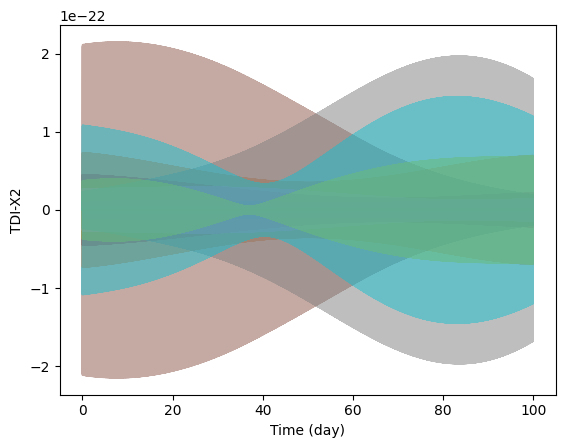

In [35]:
for i in range(10):
    plt.plot(tcb_times / DAY, results[i], alpha=0.5, linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")

#### 2) for MBHB waveforms 

In [47]:
approximant = "IMRPhenomT"
# approximant = "SEOBNRv4_opt"
mbhb_waveform_generator = MBHB_Injection(approx_method=approximant, buffer=False)

# this is actually the same as gb_response_generator
mbhb_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=X2_string,
    tcb_times=tcb_times,
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=False,
)

In [48]:
MBHB_params = {
    "chirp_mass": 400000.0,
    "mass_ratio": 0.3640815267051051,
    "spin_1z": 0.7899406190510447,
    "spin_2z": 0.015424596359292053,
    "coalescence_time": 50.0,
    "coalescence_phase": 3.2535342675592966,
    "luminosity_distance": 106039.10941463517,
    "inclination": 1.4495086550199021,
    "longitude": 3.032776598141215,
    "latitude": -1.1817968279048852,
    "psi": 0.2409146690555858,
}

#### Compute response 

In [49]:
results = mbhb_response_generator(parameters=MBHB_params, waveform_generator=mbhb_waveform_generator)

(49.98, 50.01)

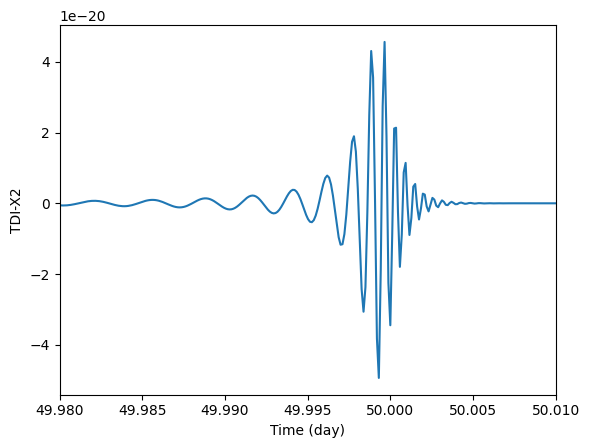

In [50]:
plt.plot(tcb_times / DAY, results)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
# plt.ylim(-1e-23, 1e-23)
plt.xlim(MBHB_params["coalescence_time"] - 0.02, MBHB_params["coalescence_time"] + 0.01)

#### 3) for general waveform (EMRI for example)

In [51]:
waveform_data = np.load("../GWData/Demo_EMRI_waveform_data.npz")
tdata, hpdata, hcdata = waveform_data["t"], waveform_data["h1"], -waveform_data["h2"]  # since h2 is -hx

general_waveform_generator = General_Injection(t_data=tdata, hp_data=hpdata, hc_data=hcdata)

# this is actually the same as gb_response_generator
general_response_generator = GeneralTDIResponse(
    orbit=orbit,
    Pstring=X2_string,
    tcb_times=tcb_times,
    use_gpu=False,
    drop_points=int(1000 / dt),
    linear_interp=False,
)

In [52]:
general_params = {
    "longitude": np.random.uniform(0, TWOPI),
    "latitude": np.arcsin(np.random.uniform(-1, 1)),
    "psi": np.random.uniform(0, PI),
}

#### Compute response

In [53]:
results = general_response_generator(parameters=general_params, waveform_generator=general_waveform_generator)

(80.0, 80.5)

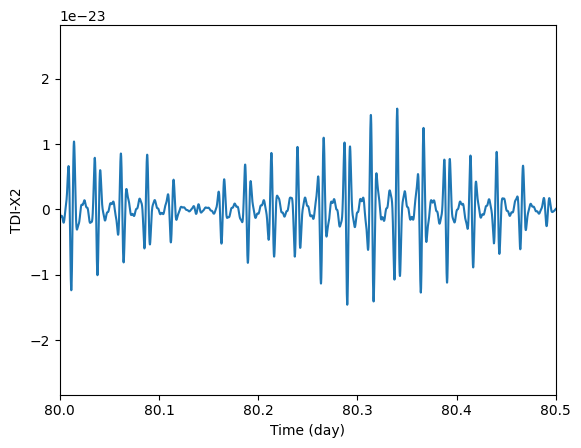

In [54]:
plt.plot(tcb_times / DAY, results)
plt.xlabel("Time (day)")
plt.ylabel("TDI-X2")
plt.xlim(80, 80.5)

## Sensitivity analysis 

Sensitivity analysis is usually a necessary step for the research on GW science.     
By drawing the signal against the sensitivity of a detector, one may have a rough assessment of the detectability of the signal.     
In the context of space-based GW detection, sensitivity is closely related to the configuration of detector constellation, as well as the choice of TDI combination scheme.    
We calculate the sensitivity of a space-based GW detector following the definition of [Class. Quantum Grav. 36 105011](https://iopscience.iop.org/article/10.1088/1361-6382/ab1101):    
$$S_X(f) \equiv \frac{P_X(f)}{\langle \mathcal{R}_X(f) \rangle_{\lambda, \beta, \psi}}$$
with $X$ representing any TDI channel, and P_X(f) the PSD of noises after TDI processing. The response function $\mathcal{R}_X(f)$ is defined as    
$$|\tilde{X}(f)|^2 = \mathcal{R} \left( |\tilde{h}_+(f)|^2 + |\tilde{h}_\times(f)|^2 \right)$$
and $\langle \cdot \rangle_{\lambda, \beta, \psi}$ denotes averaging over the sources' angular coordinates and polarization angles. 

In realistic data analysis, the definition of "noise" could be rather tricky.   
Here we make an idealistic assumption that $P_X(f)$ includes only the contribution of two instrumental noises, i.e. the optical metrology noise and test-mass acceleration noise.    
The following definitions apply to any TDI channel and any orbit configurations. 

### Set TDI scheme with the $P_{ij}$ strings

In [62]:
X2_string = {
    "12": [(1.0, []), (-1.0, ["13", "31"]), (-1.0, ["13", "31", "12", "21"]), (1.0, ["12", "21", "13", "31", "13", "31"])],
    "23": [],
    "31": [(-1.0, ["13"]), (1.0, ["12", "21", "13"]), (1.0, ["12", "21", "13", "31", "13"]), (-1.0, ["13", "31", "12", "21", "12", "21", "13"])],
    "21": [(1.0, ["12"]), (-1.0, ["13", "31", "12"]), (-1.0, ["13", "31", "12", "21", "12"]), (1.0, ["12", "21", "13", "31", "13", "31", "12"])],
    "32": [],
    "13": [(-1.0, []), (1.0, ["12", "21"]), (1.0, ["12", "21", "13", "31"]), (-1.0, ["13", "31", "12", "21", "12", "21"])],
}

A2_string, _, _ = TDIStringManipulation.AETStringsfromXString(X2_string)

### Set the configuration of orbit 
Generally, both the TDI response of signal and the TDI combination of noises are affected by the armlengths. As an example, we set the states of orbit according to our numerical orbit at a random time. 

In [63]:
orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

orbit_time = np.random.uniform(0, 100 * DAY)

Ri_test = dict()
for key in SC_labels:
    Ri_test[key] = orbit.Positionfunctions()[key](orbit_time)

nij_test = dict()
dij_test = dict()
for key in MOSA_labels:
    nij_test[key] = orbit.ArmVectorfunctions()[key](orbit_time)
    dij_test[key] = orbit.LTTfunctions()[key](orbit_time)

Ri_test, nij_test, dij_test

({'1': array([-3.76646875e+10,  1.45706836e+11,  1.32727487e+09]),
  '2': array([-3.98027598e+10,  1.44239553e+11, -1.51544619e+08]),
  '3': array([-3.70156250e+10,  1.44339262e+11, -1.25423913e+09])},
 {'12': array([0.71621094, 0.49153711, 0.49541211]),
  '13': array([-0.21694179,  0.45697023,  0.8626207 ]),
  '23': array([-0.92936272, -0.03325552,  0.36766698]),
  '21': array([-0.71625618, -0.49151363, -0.49537   ]),
  '31': array([ 0.21683503, -0.45699503, -0.86263441]),
  '32': array([ 0.92934772,  0.03323865, -0.3677064 ])},
 {'12': array(9.95698116),
  '13': array(9.98235542),
  '23': array(10.00409507),
  '21': array(9.95786366),
  '31': array(9.98223575),
  '32': array(10.00307572)})

### Calculate and plot sensitivity 
to convert to the dimensionless characteristic strain, one needs to further multiply $S(f)$ by $f$. 

100%|██████████| 1024/1024 [00:00<00:00, 5371.58it/s]


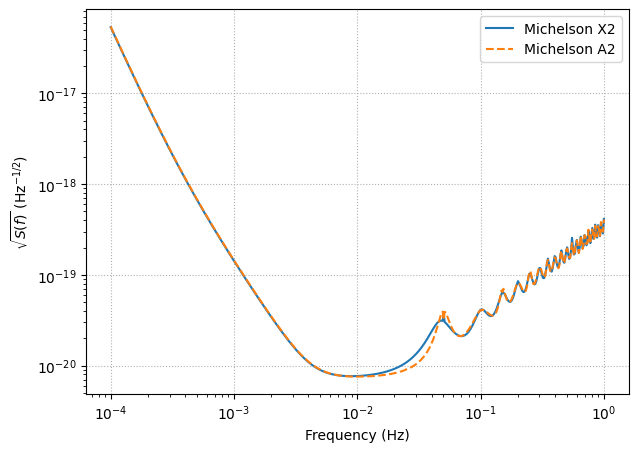

In [65]:
plt.figure(figsize=(7, 5))

sensitivity = TDISensitivity(Ri=Ri_test, nij=nij_test, dij=dij_test)

plot_freqs = np.logspace(-4, 0, 512)
plot_sens_X = sensitivity.TDI_sensitivity(f=plot_freqs, P_ij_strings=X2_string)
plt.loglog(plot_freqs, np.sqrt(plot_sens_X), label="Michelson X2")

plot_sens_A = sensitivity.TDI_sensitivity(f=plot_freqs, P_ij_strings=A2_string)
plt.loglog(plot_freqs, np.sqrt(plot_sens_A), label="Michelson A2", linestyle="--")

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\sqrt{S(f)} \ ({\rm Hz^{-1/2}})$")
plt.legend(loc="upper right")
plt.grid(linestyle=":")